# SDE Simulation Driven by Fractional Brownian Motion
- We define:
  1. `generate_fbm(T, N, H)` → fBm path
  2. `compute_increments(path)` → ΔB
  3. `simulate_sde_fbm(theta, H, sigma, T, N, X0)` → time grid, X path
  4. `plot_path(times, X, H, sigma)` → visualization


In [5]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
np.float = float
# assume these are provided elsewhere:
# from some_module import fBm, drift


In [6]:
#fBm helper functions

def fBm(T, N, H):
    '''
    Generates sample paths of fractional Brownian Motion using the Davies Harte method
    
    args:
        T:      length of time (in years)
        N:      number of time steps within timeframe
        H:      Hurst parameter
    '''
    gamma = lambda k,H: 0.5*(np.abs(k-1)**(2*H) - 2*np.abs(k)**(2*H) + np.abs(k+1)**(2*H))  
    g = [gamma(k,H) for k in range(0,N)];    r = g + [0] + g[::-1][0:N-1]

    # Step 1 (eigenvalues)
    j = np.arange(0,2*N);   k = 2*N-1
    lk = np.fft.fft(r*np.exp(2*np.pi*complex(0,1)*k*j*(1/(2*N))))[::-1]

    # Step 2 (get random variables)
    Vj = np.zeros((2*N,2), dtype=np.complex128); 
    Vj[0,0] = np.random.standard_normal();  Vj[N,0] = np.random.standard_normal()
    
    for i in range(1,N):
        Vj1 = np.random.standard_normal();    Vj2 = np.random.standard_normal()
        Vj[i][0] = Vj1; Vj[i][1] = Vj2; Vj[2*N-i][0] = Vj1;    Vj[2*N-i][1] = Vj2
    
    # Step 3 (compute Z)
    wk = np.zeros(2*N, dtype=np.complex128)   
    wk[0] = np.sqrt((lk[0]/(2*N)))*Vj[0][0];          
    wk[1:N] = np.sqrt(lk[1:N]/(4*N))*((Vj[1:N].T[0]) + (complex(0,1)*Vj[1:N].T[1]))       
    wk[N] = np.sqrt((lk[0]/(2*N)))*Vj[N][0]       
    wk[N+1:2*N] = np.sqrt(lk[N+1:2*N]/(4*N))*(np.flip(Vj[1:N].T[0]) - (complex(0,1)*np.flip(Vj[1:N].T[1])))
    
    Z = np.fft.fft(wk);     fGn = Z[0:N] 
    fBm = np.cumsum(fGn)*(N**(-H))
    fBm = (T**H)*(fBm)
    path = np.array([0] + list(fBm))
    return path.real


def generate_fbm(T, N, H, MC=1):
    """
    Generate a fractional Brownian motion path of Hurst H on [0, T].
    
    Returns:
        times: np.ndarray of shape (N,)
        B:     np.ndarray of shape (N,)
    """
    times = np.linspace(0, T, N)
    B = np.empty((N+1,MC))
    for i in range(MC):
        B[:,i] = fBm(T, N, H)
    return times, B

def compute_increments(path):
    """
    Compute discrete increments ΔB[k] = path[k+1] - path[k].
    
    Returns:
        increments: np.ndarray of shape (len(path)-1,)
    """
    return np.diff(path)


In [7]:
#Core simulation function
#theta= lam, p, q
def drift1(theta):
    return lambda x: (theta[0])*x*((np.abs(x)+1e-8)**(theta[1]))
def drift2(theta):
    return lambda x: - x*(np.abs(x)**theta[2])

def simulate_sde_fbm(theta, H, sigma, T, N, X0, MC=1):
    """
    Simulate X_t via Euler scheme:
        dX_t = b_theta(X_t) dt + sigma dB^H_t
    
    Args:
        theta: parameter(s) for the drift
        H:     Hurst exponent of the fBm
        sigma: noise coefficient
        T:     time horizon
        N:     number of discretization points
        X0:    initial condition
        MC: Monte Carlo parameter
    
    Returns:
        times: np.ndarray of shape (N,)
        X:     np.ndarray of shape (N,)
    """
    # Drift function
    b1 = drift1(theta)
    b2 = drift2(theta) 
    
    # Generate fBm and increments
    times, B = generate_fbm(T, N, H, MC)
    dB = np.empty((N,MC))
    for i in range(MC):
        #print(B[:,i].size) (this is just for debugging)
        dB[:,i] = compute_increments(B[:,i])
    #print(dB.size)  #debugging  
    dt = times[1] - times[0]
    #print(dt)
    # Prepare solution array
    X = np.empty((N,MC))
    X[0] = X0
    for k in range(N - 1):
        if theta[1]>=0:
            X[k+1,:] = X[k,:] +  (b2(X[k,:])*dt) / ( 1+ dt*np.abs(b2(X[k,:])) ) +  sigma * dB[k,:] #taming the superlinearity
            #X[k+1,:] = X[k,:] + b1(X[k,:]) * dt + (b2(X[k,:])(1+dt*np.abs(b2(X[k,:])))) *dt+  sigma * dB[k,:] #simple euler scheme
            #print(X[k+1,:].min())
        if theta[1]<0:
            X[k+1,:] = X[k,:] + b1(X[k,:]) / (1+dt*np.abs(b1(X[k,:]))) * dt + ( b2(X[k,:]) / ( 1+ dt*np.abs(b2(X[k,:])) ) )*dt +  sigma * dB[k,:] #taming the superlinearity
    
    X_final = np.clip(X[N-1,:],-5,5)
    return times, X, X_final



In [8]:
#Plotting helper

def plot_path(times, X, H=None, sigma=None):
    """
    Plot the simulated path X over times.
    """
    plt.figure(figsize=(8,4))
    plt.plot(times, X, label=r'$X_t$')
    plt.xlabel('Time')
    plt.ylabel('X')
    title = 'SDE Path'
    if H is not None and sigma is not None:
        title += f' (H={H}, σ={sigma})'
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


1.9075474304134121


(array([ 5., 14.,  6., 15., 16., 12.,  9., 12.,  8.,  3.]),
 array([-1.61786319, -1.26532213, -0.91278107, -0.56024001, -0.20769894,
         0.14484212,  0.49738318,  0.84992424,  1.20246531,  1.55500637,
         1.90754743]),
 <BarContainer object of 10 artists>)

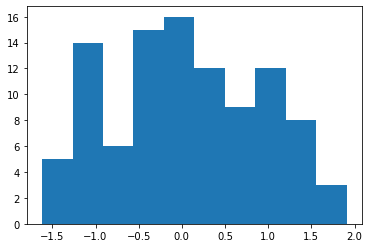

In [9]:
# Example usage

# parameters
theta = np.array([1,-1,2])  # your drift parameter(s)
H     = 0.3
sigma = 1
T     = 10
N     = 1000
X0    = 1
MC    = 100

# simulate
times, X, X_final = simulate_sde_fbm(theta, H, sigma, T, N, X0, MC)

# visualize
#plot_path(times, X, H, sigma)
print(X_final.max())
plt.hist(X_final)

# density simulation at time T
- We define:
  1.`estimate_density — runs the SDE simulation to simulate the density

In [10]:
def sigmoid(x):
    return 1/(1+np.exp(-x))
def inv_sigmoid(x):
    return np.log(x)-np.log(1-x)

$1/N \sum (f(X_i)-g(X_i))^2 / (1+f(X_i)) \rightarrow \int |f(x)-g(x)|^2 \times f(x)/(1+f(x))$ 

In [11]:
from sklearn.neighbors import KernelDensity
def estimate_density(theta, H, sigma, T, N, X0=0 ,MC=1):
    """
    Simulate one path of the SDE and estimate the density at the array x
    Args:
      theta    : parameters for the drift
      H        : Hurst exponent
      sigma    : noise coefficient
      T        : time horizon
      N        : number of points
      X0       : initial value (default 0)
      
    Returns:
      density_est  : float, the estimated f(X_T)
      Y_final : transformed X_T via sigmoid
      X_final-X0 : X_T-X_0
    """
    # 1. simulate the path
    times, X, X_final = simulate_sde_fbm(theta, H, sigma, T, N, X0, MC)
    Y_final = sigmoid(X_final) #for simplicity, i'm always taking the image of the densities by a sigmoid
    #print(X_final) #debugging
    #print(Y_final.max(),Y_final.min())
    Y_final_kde = np.asarray(Y_final)[:, None]
    
    #2. estimate the density with a gaussian kernel
    kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(Y_final_kde)
    
    sigma_prime = Y_final*(1-Y_final)
    
    density_est = np.exp(kde.score_samples(np.asarray(Y_final)[:, None]))
    
    density_est = density_est * sigma_prime
    
    density_est = np.clip(density_est, 1e-10, np.inf)
    
    return density_est, Y_final, X_final

/Users/elmehdi/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [12]:
#Example usage

theta   = np.array([3.        , -4.99999998,  2.89381672])#np.array([1,-3,1])      # your drift parameter(s)
H       = 0.5
sigma   = 1
T       = 1.0      # longer horizon to approximate stationarity
N       = 1000
X0      = 0.1
MC      = 100

density_est, Y_final, X_final = estimate_density(theta, H, sigma, T, N, X0, MC)
#print(f"Estimated density f({x}) = {density_est}")

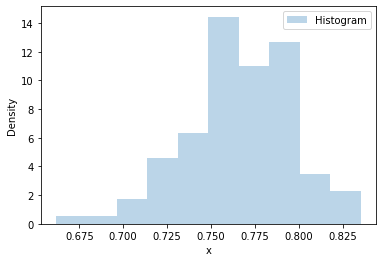

In [13]:
#Example of plot
#plt.plot(x-X0, density_est, label=f'KDE (bw={0.2})')
plt.hist(Y_final, density=True, alpha=0.3, label='Histogram')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.show()

# Target density

In [14]:
#Custom density function

import numpy as np

def custom_density(x, lam, p, q):
    """
    Compute the (unnormalized) density
        f(x) = exp( - (λ/p) * |x|^p  -  (1/q) * |x|^q )
    
    Args:
        x   : float or array-like
        lam : positive float, the λ parameter
        p   : positive float exponent for the first term
        q   : positive float exponent for the second term
    
    Returns:
        float or np.ndarray of same shape as x
    """
    x = np.asarray(x)
    return np.exp( (lam / p) * np.abs(x)**p
                  - (1.0  / q) * np.abs(x)**q)

def log_g(x, lam, p, q):
    """Unnormalized log-density: log g(x)"""
    x = float(x)
    return (lam / p) * np.abs(x)**p - (1.0 / q) * np.abs(x)**q

def metropolis_sampler(log_g, x0, n_samples, step=1.0, burn=1000, args=()):
    """
    Metropolis-Hastings sampler from a 1D log-density.
    
    Args:
        log_g      : function(x, *args) → log density (unnormalized)
        x0         : float, initial point
        n_samples  : number of samples to return (after burn-in)
        step       : proposal std dev (tuning parameter)
        burn       : number of burn-in steps to discard
        args       : extra arguments for log_g (e.g. lam, p, q, X0)

    Returns:
        np.ndarray of shape (n_samples,)
    """
    samples = []
    x = x0
    total = burn + n_samples

    for i in range(total):
        x_prop = np.random.normal(0, step)
        log_accept_ratio = log_g(x_prop, *args) - log_g(x, *args)
        if np.log(np.random.rand()) < log_accept_ratio:
            x = x_prop
        if i >= burn:
            samples.append(x)

    return np.array(samples)


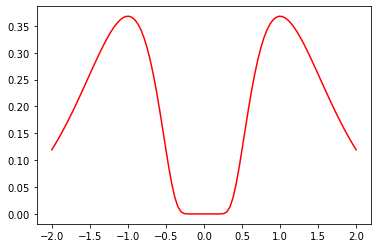

In [15]:
# scalar example
#print(custom_density(0.5, lam=2.0, p=4, q=6))

# vector example
xs = np.linspace(-2, 2, 100)
fs = custom_density(xs, lam=1, p=-2, q=2)
plt.plot(xs,fs, color='r')

<ipython-input-14-d961e99dd477>:26: RuntimeWarning: divide by zero encountered in scalar power
  return (lam / p) * np.abs(x)**p - (1.0 / q) * np.abs(x)**q


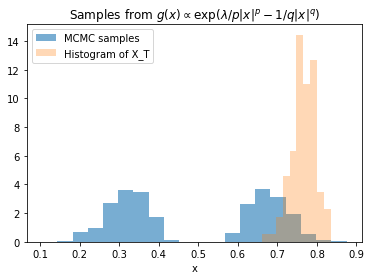

In [17]:
# Parameters
lam = 1.0
p = -2
q = 2
#X0 = 0.1

# Run sampler
samples = metropolis_sampler(log_g, x0=0.0, n_samples=10000, step=0.5, args=(lam, p, q,))

# Plot the result
plt.hist(sigmoid(samples), bins=20, density=True, alpha=0.6, label='MCMC samples')
plt.hist(Y_final, density=True, alpha=0.3, label='Histogram of X_T')
plt.title("Samples from $g(x) \propto \\exp(\\lambda/p |x|^p - 1/q |x|^q)$")
plt.xlabel('x')
plt.legend()
plt.show()

### Objective function

In [18]:
def compute_objective(theta, H, sigma, T, N, lam, p, q, X0, MC):
    """
    Compute the objective
        1/n * Σ_i (density_est(x_i)-custom_density(x_i))**2 / density_est(x_i)
    where:
      - density_est(x_i) is returned by estimate_density(...)

    Args:
        theta     : parameter(s) for the drift
        H         : Hurst exponent
        sigma     : noise coefficient
        T         : time horizon
        N         : number of time-steps
        lam, p, q : parameters of the unnormalized density p(x)
        X0        : initial condition for SDE (default 0)

    Returns:
        float : the computed objective value
    """    
    # estimate_density 
    density_est, y_final, x_final = estimate_density(theta, H, sigma, T, N, X0, MC)
    
    term1 = np.array(density_est)
    #print(term1)
    # 2) Compute custom_density
    term2 = custom_density(x_final, lam, p, q)
    
    integrand = (term1 - term2)**2 / term1
    return np.log(integrand.mean() + 1e-12)

In [19]:
#Example usage
compute_objective(np.array([1, -2.,  5.]), 0.2, 1, 1, 1000, 1, -2, 2, 0.1, 100)

-2.0825517359973795

# Optimisation procedure

In [20]:
#Run these commands first for pytorch
#conda install nb_conda 
#conda install ipykernel 
#%pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113 #download package needeed for optim

In [21]:
import torch
from torch.optim import SGD

In [87]:
#Example usage
T=1
N=1000
lam=1
p=-2
q=2
MC=10000
X0=0.1
H = 0.3
#train_params(lam, p, q,T, N, MC, X0, lr=1e-1,epochs=200,print_every=5)

## Minimising the Wasserstein distance and considering ergodic averages

In [88]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [126]:
def simulator(param,n_samples=1000):
    _,X,_ = simulate_sde_fbm(np.array([param[0],param[1],param[2]]), sigmoid(param[4])/2, 1, T, n_samples, param[3], MC=1)
    return X


def wp_1d(param, simulator, target_samples, n_samples=1000, p=1):
    """
    Compute the empirical 1D Wasserstein-p distance between:
      • samples = simulator(theta, n_samples)
      • target_samples (array of length >= n_samples)
    
    Parameters
    ----------
    theta : any
        Parameter passed to your simulator.
    simulator : callable
        simulator(theta, n_samples) -> array_like of shape (n_samples,)
    target_samples : array_like
        Samples from your target distribution (length >= n_samples).
    n_samples : int, optional (default=1000)
        Number of points to draw from the simulator.
    p : float, optional (default=1)
        Order of the Wasserstein distance (1 or 2 typically).
    
    Returns
    -------
    Wp : float
        The empirical 1D Wasserstein-p distance.
    """
    # draw from the model
    x = np.asarray(simulator(param, n_samples)).ravel()
    if x.shape[0] != n_samples:
        raise ValueError(f"simulator must return {n_samples} samples, got {x.shape[0]}")
    
    # draw (or subsample) target
    y = np.asarray(target_samples).ravel()
    if y.shape[0] < n_samples:
        raise ValueError(f"target_samples must have at least {n_samples} points")
    # randomly sub-select n_samples from target for fairness
    y = np.random.choice(y, size=n_samples, replace=False)
    
    # sort both
    x_sorted = np.sort(x)
    y_sorted = np.sort(y)
    
    # compute the mean |x_i - y_i|^p
    return np.mean(np.abs(x_sorted - y_sorted)**p)**(1/p)

In [127]:
target_samples = metropolis_sampler(log_g, x0=0.0, n_samples=10000, step=0.5, args=(lam, p, q,))
print(target_samples)

[-0.64440092 -0.64440092 -0.64440092 ... -0.62927106 -0.62927106
  1.14673493]


<ipython-input-14-d961e99dd477>:26: RuntimeWarning: divide by zero encountered in scalar power
  return (lam / p) * np.abs(x)**p - (1.0 / q) * np.abs(x)**q


In [ ]:
from cma import CMAEvolutionStrategy

def evaluate(param):
    K = 10
    vals = [wp_1d(param, simulator, target_samples, n_samples=10000, p=2) for k in range(K)]
    return float(np.mean(vals))
# initialize CMA-ES to optimize theta (1-D) between, say, -5 and +5
#init_mean = np.array([1, -2,  5, 1, 0, -0.5]) #theta,sigma,x0,H
init_mean = np.array([1, -2,  5, 0, -0.5]) #theta,sigma,x0,H

init_std  = 0.5
es = CMAEvolutionStrategy(init_mean, init_std, {'popsize': 10, 'maxiter':100})
#es.opts.set({'c_sigma': 0.2, 'damping': 0.8})

es.optimize(lambda th: evaluate(th))
#while not es.stop():
#    solutions = es.ask()
#    fitnesses = [wp_1d(param, simulator, target_samples, n_samples=1000, p=1)
#                 for param in solutions]
#    es.tell(solutions, fitnesses)
param_opt, _ = es.result.xbest, es.result.fbest
print("Optimal param:", param_opt)

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 5 (seed=1006945, Wed Jun 25 15:24:51 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 5.463170462805232e-01 1.0e+00 5.02e-01  5e-01  6e-01 0:41.6
    2     20 4.732225518669493e-01 1.3e+00 4.69e-01  4e-01  5e-01 1:20.8
    3     30 3.585550176409880e-01 1.4e+00 5.18e-01  5e-01  6e-01 2:00.1
    4     40 3.426904802801792e-01 1.7e+00 6.62e-01  6e-01  8e-01 2:39.8
    5     50 3.242106638392156e-01 1.6e+00 8.08e-01  7e-01  9e-01 3:18.7
    6     60 2.925769667287052e-01 1.7e+00 1.05e+00  9e-01  1e+00 3:57.4
    7     70 3.020069173795966e-01 1.9e+00 1.27e+00  1e+00  2e+00 4:37.9
    8     80 2.937876255345349e-01 2.0e+00 1.41e+00  1e+00  2e+00 5:16.7
    9     90 2.912113354257513e-01 2.1e+00 1.75e+00  1e+00  2e+00 5:55.1
   10    100 2.879159450296706e-01 2.3e+00 2.21e+00  1e+00  3e+00 6:32.6
   11    110 2.859852546083351e-01 2.3e+00 2.32e+00  2e+00  3e+00 7:06.8
   12    120 2.837491724575020e-0

In [115]:
#Looking at the density with the found parameters
def test_param(param):
    theta, X0 = param[:3],param[3]
    H = sigmoid(param[4]) #plug your parameters here
    density_est, Y_final, X_final = estimate_density(theta, H, sigma, T, N, X0, MC)
    #Example of plot
    #print(Y_final.min())
    plt.hist(Y_final, bins=20, density=True, alpha=0.3, label='estimated sample')
    samples = metropolis_sampler(log_g, x0=0.0, n_samples=10000, step=0.5, args=(lam, p, q))
    plt.hist(sigmoid(samples), bins=20, density=True, alpha=0.6, label='target samples')
    plt.xlabel('x')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

<ipython-input-14-d961e99dd477>:26: RuntimeWarning: divide by zero encountered in scalar power
  return (lam / p) * np.abs(x)**p - (1.0 / q) * np.abs(x)**q


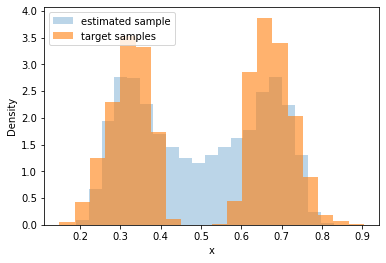

In [116]:
test_param(param_opt)

## Using Cma.fmin

In [35]:
#Run these commands first for cma
#pip install cma

In [36]:
import cma

In [55]:
def sigmoid(x):
    return 1/(1+np.exp(-x))
def transformation(x):
    return np.array([sigmoid(x[0])*3,sigmoid(x[1])*(-5),1+sigmoid(x[2])*5]), sigmoid(x[3])/2

In [56]:
# p+1 > 1/2 -1/(2H)
1/2 +1/(2 * 0.1)

5.5

In [58]:
#Optim with cma
def objective_np(vec):
    theta,H =transformation(vec)      # your unpack‐and‐clip logic
    return compute_objective(theta, H, 1, T, N, lam, p, q, X0, MC)

def objective_H(vec):
    theta,_ =transformation(vec)      # your unpack‐and‐clip logic
    return compute_objective(theta, 0.1, 1, T, N, lam, p, q, X0, MC)

# initial guess and step‐size
x0 = np.array([-0.8,-0.3,1.5, -1])
theta,_= transformation(x0)
print(theta)

[ 0.93007656 -2.12778742  5.08787238]


In [61]:
res = cma.fmin(objective_H, x0, sigma0=1,
               options={'maxiter':10, 'popsize':30})
print("CMA‐ES result:", res[0])

(15_w,30)-aCMA-ES (mu_w=8.6,w_1=20%) in dimension 4 (seed=306494, Tue May 13 11:20:43 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     30 -2.269696194774461e+00 1.0e+00 1.22e+00  1e+00  2e+00 0:31.5
    2     60 -2.386629462148532e+00 1.8e+00 1.98e+00  2e+00  3e+00 1:02.4
    3     90 -2.483414952253486e+00 2.5e+00 2.78e+00  2e+00  4e+00 1:33.7
    4    120 -2.544180754128326e+00 2.5e+00 3.50e+00  3e+00  6e+00 2:04.8
    5    150 -2.539219120679689e+00 2.8e+00 3.97e+00  3e+00  6e+00 2:35.0
    6    180 -2.629100072566633e+00 3.4e+00 3.75e+00  2e+00  5e+00 3:05.4
    7    210 -2.677815859159422e+00 3.1e+00 3.85e+00  2e+00  5e+00 3:35.9
    8    240 -2.517607040389788e+00 3.0e+00 3.66e+00  2e+00  5e+00 4:06.5
    9    270 -2.534208379001431e+00 3.6e+00 3.55e+00  2e+00  5e+00 4:36.7
   10    300 -2.702813583240436e+00 3.9e+00 3.21e+00  1e+00  3e+00 5:07.4
termination on maxiter=10 (Tue May 13 11:25:52 2025)
final/bestever f-value = -2.426248e+00 -2.7

In [62]:
#Checking the found parameters
sol = res[0]
print("estimated lam,p,q and H are", transformation(sol))
print("tru parameters lam,p,q are", lam, p, q)

estimated lam,p,q and H are (array([ 0.52606329, -4.99809597,  1.00085526]), 0.04567371254571758)
tru parameters lam,p,q are 1 -2 2


In [67]:
#Looking at the density with the found parameters
def test_param(sol):
    theta, H = transformation(sol) #plug your parameters here
    density_est, Y_final, X_final = estimate_density(theta, H, 1, T, N, X0, MC)
    #Example of plot
    #print(Y_final.min())
    plt.hist(Y_final, bins=20, density=True, alpha=0.3, label='Histogram')
    samples = metropolis_sampler(log_g, x0=0.0, n_samples=10000, step=0.5, args=(lam, p, q))
    plt.hist(sigmoid(samples), bins=20, density=True, alpha=0.6, label='MCMC samples')
    plt.xlabel('x')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

<ipython-input-26-d961e99dd477>:26: RuntimeWarning: divide by zero encountered in scalar power
  return (lam / p) * np.abs(x)**p - (1.0 / q) * np.abs(x)**q


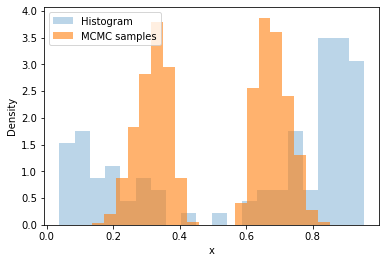

In [68]:
test_param(sol)

## To try later: CMA with bounds

In [ ]:
#Try with bounds on the parameters
lower_bounds = []
upper_bounds = []
res = cma.fmin(objective_np, x0, sigma0=1, 
               options={'maxiter':20, 'popsize':30, 'bounds': [lower_bounds, upper_bounds]})
print("CMA‐ES result:", res[0])